In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import pickle as pkl

import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Draw

from tdc.single_pred import Tox
from ersilia import ErsiliaModel

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN

from scripts.load_dataset import DataDownloader
from scripts.clean_transform_data import DataProcessor
from scripts.exploratory_analysis import ExploratoryDataAnalysis
from scripts.feature_engineering import Featurizer
from scripts.train_evaluate_model import DatasetProcessor, Modelling

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### **Getting to Know Our Data**  

In [2]:
while True:
    dataset_name = input("Dataset name (AMES or hERG): ").strip()
    if dataset_name in ["AMES", "hERG"]:
        break
    print("Invalid input. Please enter either 'AMES' or 'hERG'.")

dataset_name = "hERG"
downloader = DataDownloader()
df, splits = None, None

Dataset name (AMES or hERG):  hERG


In [3]:
while True:
    use_existing_data = input("Use Existing Data? (Y/N): ").strip()
    if use_existing_data in ["Y", "N"]:
        break
    print("Invalid input. Please enter either 'Y' or 'N'.")
#use_existing_data = 'Y'

Use Existing Data? (Y/N):  Y


In [4]:
if use_existing_data == 'N':
    print("\nDownloading data...")
    df, splits = downloader.fetch_dataset(name = dataset_name)
else:
    print("\nLoading existing data...")
    try:
        df = pd.read_csv(f'../data/{dataset_name}/{dataset_name}.csv')
        train = pd.read_csv(f'../data/{dataset_name}/train.csv') 
        validation = pd.read_csv(f'../data/{dataset_name}/validation.csv') 
        test = pd.read_csv(f'../data/{dataset_name}/test.csv') 
        splits = {"train": train, "validation": validation, "test": test}
        print("Data successfully loaded.")
    except FileNotFoundError as e:
        print(f"Error: {e}. Dataset not found, attempting to download...")
        df, splits = downloader.fetch_dataset(name = dataset_name)


Loading existing data...
Data successfully loaded.


In [5]:
files_to_preprocess = [f"../data/{dataset_name}/{key}.csv" for key in splits.keys()]
files_to_preprocess

['../data/hERG/train.csv',
 '../data/hERG/validation.csv',
 '../data/hERG/test.csv']

In [6]:
np.median([len(drug) for drug in df.Drug])

50.0

In [7]:
for file in files_to_preprocess:
    processor = DataProcessor(input_csv = file, output_csv = file)
    processor.process_csv()

2025-03-31 19:59:35,443 - INFO - No missing Drug_IDs found. No processing needed.
2025-03-31 19:59:35,470 - INFO - No missing Drug_IDs found. No processing needed.
2025-03-31 19:59:35,470 - INFO - No missing Drug_IDs found. No processing needed.
2025-03-31 19:59:35,488 - INFO - No missing Drug_IDs found. No processing needed.
2025-03-31 19:59:35,488 - INFO - No missing Drug_IDs found. No processing needed.
2025-03-31 19:59:35,488 - INFO - No missing Drug_IDs found. No processing needed.


In [8]:
train.head()

,Drug_ID,Drug,Y
0,DELAVIRDINE,CC(C)Nc1cccnc1N1CCN(C(=O)C2=CC3=C[C@H](NS(C)(=...,0.00
1,SOPHOCARPINE,O=C1C=CC[C@@H]2[C@H]3CCCN4CCC[C@H](CN12)[C@H]34,0.00
2,RALOXIFENE,O=C(c1ccc(OCC[NH+]2CCCCC2)cc1)c1c(-c2ccc(O)cc2...,0.00
3,N-DEMETHYLOLANZAPINE,Cc1cc2c(s1)Nc1ccccc1N=C2N1CCNCC1,1.00
4,SUNITINIB,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,1.00


#### **Brief EDA** 

2025-03-31 19:59:35,718 - INFO - Absolute data path: /home/gentroyal/outreachy-temp/data/hERG/hERG.csv
2025-03-31 19:59:35,721 - INFO - Absolute figure directory: /home/gentroyal/outreachy-temp/data/figures/hERG
2025-03-31 19:59:35,731 - INFO - Figure directory verified at: /home/gentroyal/outreachy-temp/data/figures/hERG
2025-03-31 19:59:35,743 - INFO - 451 drugs are classified as blockers
2025-03-31 19:59:35,746 - INFO - 204 drugs are classified as non-blockers


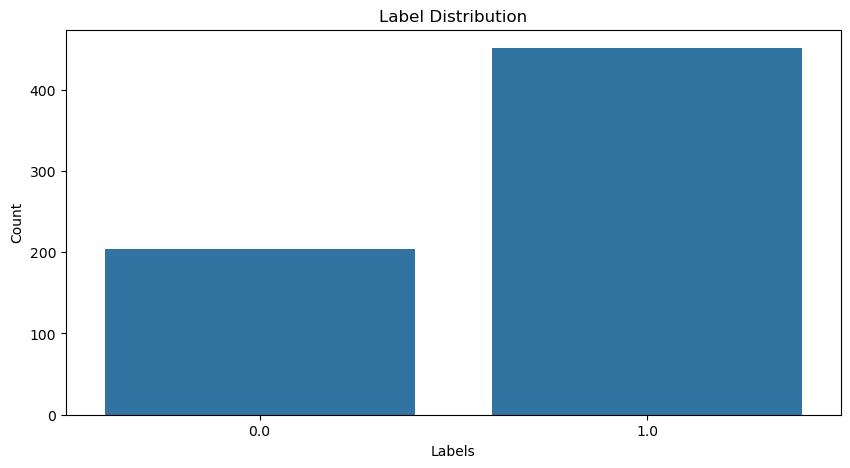

2025-03-31 19:59:36,492 - INFO - Saved figure to: /home/gentroyal/outreachy-temp/data/figures/hERG/label_distribution.png


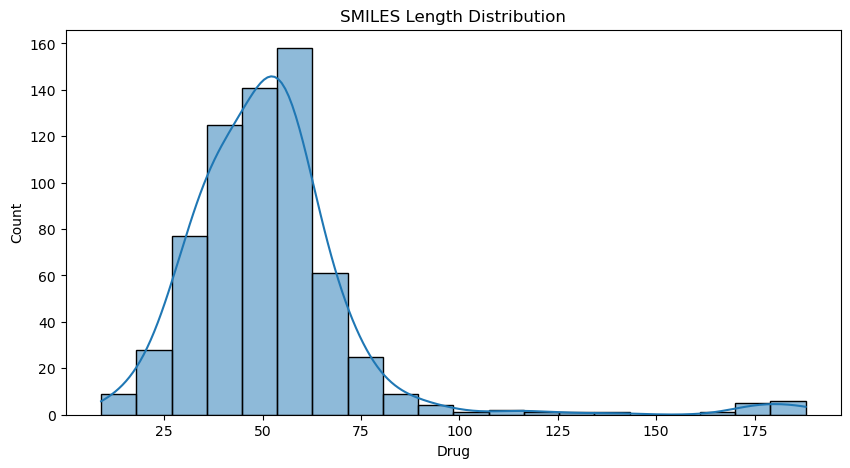

2025-03-31 19:59:37,301 - INFO - Saved figure to: /home/gentroyal/outreachy-temp/data/figures/hERG/smiles_length.png
2025-03-31 19:59:37,304 - INFO - EDA for hERG completed successfully.


In [9]:
explore = ExploratoryDataAnalysis(dataset_name)
explore.generate_eda()

**Comment:** There are 451 blockers (classed as 1) and and 204 nonblockers (classed as 0). Since there is a huge difference in the number of samples in both classes, it means that there is an imbalance and we need to address this before we can train our machine learning model.

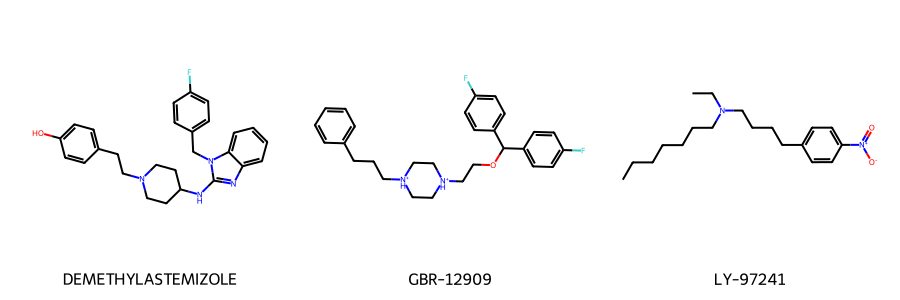

In [10]:
smiles_list = df["Drug"].iloc[:3].tolist()  # First 3 SMILES
drug_names = df["Drug_ID"].iloc[:3].tolist()  # Their  Names

mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow = 3, subImgSize=(300, 300), legends=drug_names)

**Comment:** 

In [11]:
featuriser = "eos5guo"
!ersilia fetch $featuriser #Uncomment this line if model has not been fetched

⬇️  Fetching model eos5guo: erg-descs
👎 Model eos5guo failed to fetch! Model already exists on your system. If you want to fetch it again, please delete the existing model first.


### **Featurizer**  

In [12]:
count = len(glob(f"../data/{dataset_name}/*{featuriser}_featurized*"))
files = ['train', 'test', 'validation']

print("\nPerforming Featurisation...")
if count == 0:
    featurizer = Featurizer(model_id = featuriser)
    
    for file in files:
        output_path = featurizer.featurize(input_file = file, dataset_name = dataset_name)
else:
    print("\nData has already by Featurised...")


Performing Featurisation...

Data has already by Featurised...


### Building a ML Model

#### Loading Data for Preprocessing

In [13]:
data_processing = DatasetProcessor(dataset_name = dataset_name, splits = splits, featuriser = featuriser)
modelling = Modelling(dataset_name = dataset_name)

In [14]:
(X_train, y_train, 
            X_test, y_test, 
            X_val, y_val, 
            X_train_smote, y_train_smote, 
            X_train_over, y_train_over, 
            X_train_hybrid, y_train_hybrid)= data_processing.preprocess_and_resample()

train_sets, configs = modelling.model_config(X_train, y_train, 
            X_train_over, y_train_over, 
            X_train_smote, y_train_smote, 
            X_train_hybrid, y_train_hybrid)

In [15]:
with open('../models/herg_model.pkl', "rb") as f:
    all_model_results = pkl.load(f)

best_roc_auc = 0
best_model = None
results = None

for model, results in all_model_results.items():
    roc_score = results['test_metrics']['roc_auc']
    
    if roc_score > best_roc_auc:
        best_roc_auc = roc_score
        best_model = model
        best_results = results

In [16]:
if dataset_name != 'hERG':
    train_sets, configs = modelling.model_config(X_train, y_train, 
            X_train_over, y_train_over, 
            X_train_smote, y_train_smote, 
            X_train_hybrid, y_train_hybrid)
    
    model_results = {}
    
    for train_set_name, (X_train_set, y_train_set) in train_sets.items():
        print(train_set_name)
        model, model_result = modelling.apply_trained_model(best_model, X_train_set, y_train_set, X_test, y_test, X_val, y_val)
        model_results[model] = model_result
    
    best_model, best_results = modelling.evaluate_model(model_results)

Best Model: RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=300,
                       n_jobs=-1, random_state=42)
Best ROC-Score: 0.8223684210526315
+------------------+--------------------+--------------------+--------------------+
|                  | Train              | Validation         | Test               |
+==================+====================+====================+====================+
| confusion_matrix | (78, 66, 4, 314)   | (11, 14, 2, 40)    | (7, 31, 1, 101)    |
+------------------+--------------------+--------------------+--------------------+
| accuracy         | 0.8484848484848485 | 0.7611940298507462 | 0.7714285714285715 |
+------------------+--------------------+--------------------+--------------------+
| precision        | 0.8263157894736842 | 0.7407407407407407 | 0.7651515151515151 |
+------------------+--------------------+--------------------+--------------------+
| recall           | 0.9874213836477987 | 0.9523809523809523 | 0.99019

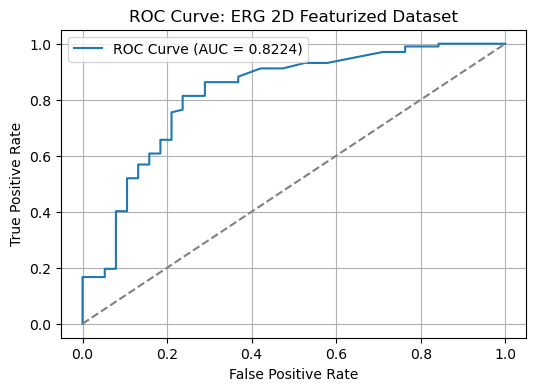

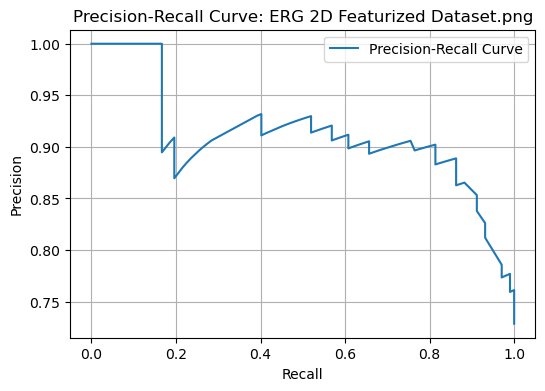

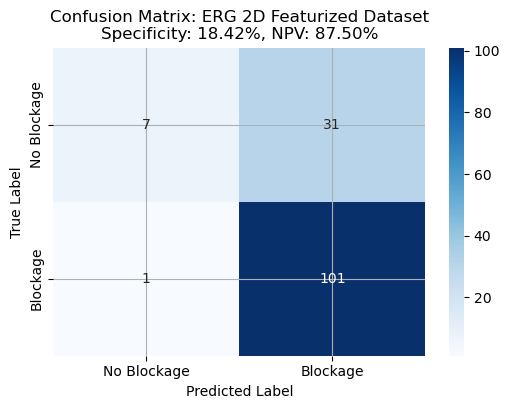

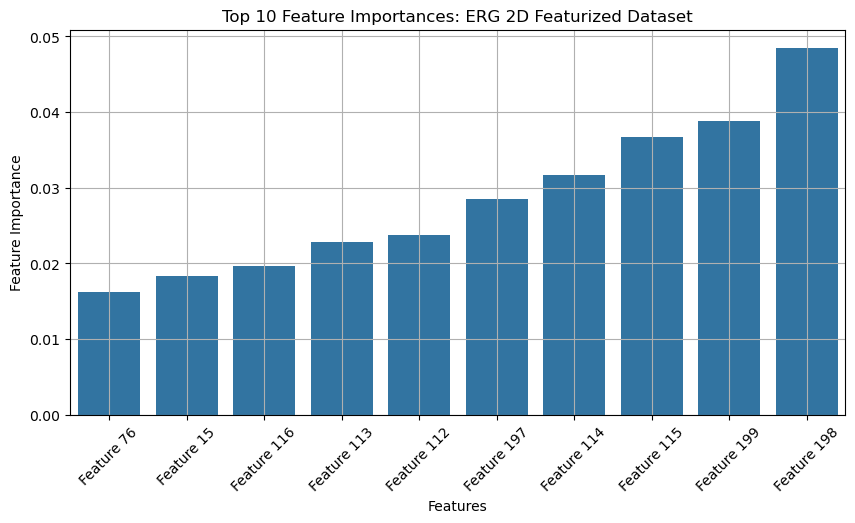

In [17]:
modelling.visualize_model(best_model, best_results, graph_title = "ERG 2D Featurized Dataset", y_test = y_test)

In [18]:
This is left uncommented deliberately

SyntaxError: invalid syntax (4158410104.py, line 1)

### Model Training Process

#### Loading Data for Preprocessing

In [19]:
def load_featurised_dataset(featuriser):
    featurised_partition = [f"../data/{dataset_name}/{key}_{featuriser}_featurized.csv" for key in splits.keys()]
    train = pd.read_csv(featurised_partition[0])
    train.drop(columns = ['key', 'input'], inplace = True)
    validation = pd.read_csv(featurised_partition[1])
    validation.drop(columns = ['key', 'input'], inplace = True)
    test = pd.read_csv(featurised_partition[2])
    test.drop(columns = ['key', 'input'], inplace = True)

    return train, validation, test

In [20]:
def prepare_features_and_target(df, target = 'Y'):
    X = df.drop(columns = [target])
    y = df[target]

    if featuriser == 'eos24ci':
        new_cols = X.columns.tolist()
        xters = [chr(char) for char in range(ord('a'), ord('z') + 1)][:10]
        
        for i, (char, col) in enumerate(zip(X.columns[-10:], xters)):
            new_cols[-10 + i] = char[:-1] + col  # Replace only the last character
        
        X.columns = new_cols
        
    nan_rows = X.isna().sum(axis=1) > 0
    X = X[(X != 0).any(axis = 1) & X.notna().any(axis = 1)]
    y = y.loc[X.index]
    
    df = X.merge(y, left_on = X.index, right_on = y.index, how = 'inner').drop(columns = ['key_0'])
    
    return df

In [21]:
def get_scaled_set(train, test, val, target = 'Y'):
    X_train, y_train = train.drop(columns = [target]), train[target]    
    X_test, y_test = test.drop(columns = [target]), test[target]
    X_val, y_val = val.drop(columns = [target]), val[target]

    zero_columns = X_train.columns[(X_train.nunique() == 1)]
    print(zero_columns)
    
    X_train.drop(columns = zero_columns, inplace = True)
    X_test.drop(columns = zero_columns, inplace = True)
    X_val.drop(columns = zero_columns, inplace = True)

    scalar = StandardScaler()
    X_train_scaled = scalar.fit_transform(X_train)
    X_test_scaled = scalar.transform(X_test)
    X_val_scaled = scalar.transform(X_val)

    return X_train_scaled, y_train, X_test_scaled, y_test, X_val_scaled, y_val

In [22]:
def get_scaled_set(train, test, val, target = 'Y'):
    X_train, y_train = train.drop(columns = [target]), train[target]    
    X_test, y_test = test.drop(columns = [target]), test[target]
    X_val, y_val = val.drop(columns = [target]), val[target]

    zero_columns = X_train.columns[(X_train.nunique() == 1)]
    print(zero_columns)
    
    X_train.drop(columns = zero_columns, inplace = True)
    X_test.drop(columns = zero_columns, inplace = True)
    X_val.drop(columns = zero_columns, inplace = True)

    scalar = StandardScaler()
    X_train_scaled = scalar.fit_transform(X_train)
    X_test_scaled = scalar.transform(X_test)
    X_val_scaled = scalar.transform(X_val)

    return X_train_scaled, y_train, X_test_scaled, y_test, X_val_scaled, y_val

#### Addressing Imbalance

In [23]:
def preprocess_and_resample(featuriser, target='Y'):
    # Load dataset
    train, validation, test = load_featurised_dataset(featuriser)
    
    # Prepare features and target
    train = prepare_features_and_target(train, target=target)
    test = prepare_features_and_target(test, target=target)
    val = prepare_features_and_target(validation, target=target)
    
    # Scale dataset
    X_train, y_train, X_test, y_test, X_val, y_val = get_scaled_set(train, test, val, target=target)
    
    # SMOTE (Oversampling)
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Random Oversampling
    oversampler = RandomOverSampler(random_state=42)
    X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
    
    # Hybrid (SMOTE + ENN)
    smote_enn = SMOTEENN(random_state=42)
    X_train_hybrid, y_train_hybrid = smote_enn.fit_resample(X_train, y_train)
    
    return (X_train, y_train, 
            X_test, y_test, 
            X_val, y_val, 
            X_train_smote, y_train_smote, 
            X_train_over, y_train_over, 
            X_train_hybrid, y_train_hybrid
           )

#### RandomForest Classifier

In [24]:
def train_randomforest_cv(X_train, y_train, X_test, y_test, X_val, y_val, class_weight, 
                           use_stratified_kfold=False, use_gridsearch=False):
    
    # Base hyperparameters
    rf_params = {
        "n_estimators": 200,
        "criterion": "gini",
        "min_samples_split": 5,
        "min_samples_leaf": 5,
        "max_features": "sqrt",
        "random_state": 42,
        "n_jobs": -1,
    }


    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    # Adjust max_depth and class_weight
    rf_params["max_depth"] = 4 if class_weight else 3
    if class_weight:
        rf_params["class_weight"] = class_weight_dict

    # Initialize the classifier
    rf = RandomForestClassifier(**rf_params)

    # Grid Search for Hyperparameter Tuning
    if use_gridsearch:
        param_grid = {
            "n_estimators": [100, 200, 300],
            "max_depth": [5],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 5, 10],
            "max_features": ["sqrt", "log2"]
        }

        grid_search = GridSearchCV(rf, param_grid, cv = 5, scoring="roc_auc", n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        rf = grid_search.best_estimator_
        print("\nBest Parameters from GridSearchCV:", grid_search.best_params_)

    # StratifiedKFold Cross-Validation
    if use_stratified_kfold:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []

        for train_idx, val_idx in cv.split(X_train, y_train):
            X_t, X_v = X_train[train_idx], X_train[val_idx]
            y_t, y_v = y_train[train_idx], y_train[val_idx]

            rf.fit(X_t, y_t)
            y_pred_v = rf.predict(X_v)
            cv_scores.append(roc_auc_score(y_v, y_pred_v))

        print("\nCross-Validation ROC AUC Scores:", cv_scores)
        print("Mean ROC AUC:", sum(cv_scores) / len(cv_scores))

    # Train final model on full training data
    rf.fit(X_train, y_train)
    
    def compute_metrics(y_true, y_pred, y_proba, dataset_name):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        roc_auc = roc_auc_score(y_true, y_proba)

        # Print results inside the function
        print("=" * 50)
        print(f"{dataset_name} Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print("=" * 50)

        return {
            "confusion_matrix": (tn, fp, fn, tp),
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
            "roc_auc": roc_auc
        }

    # Compute metrics for Train, Validation, and Test sets
    y_train_pred = rf.predict(X_train)
    y_train_proba = rf.predict_proba(X_train)[:, 1]
    train_metrics = compute_metrics(y_train, y_train_pred, y_train_proba, "Train")

    y_val_pred = rf.predict(X_val)
    y_val_proba = rf.predict_proba(X_val)[:, 1]
    val_metrics = compute_metrics(y_val, y_val_pred, y_val_proba, "Validation")

    y_test_pred = rf.predict(X_test)
    y_test_proba = rf.predict_proba(X_test)[:, 1]
    test_metrics = compute_metrics(y_test, y_test_pred, y_test_proba, "Test") 
    
    # Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_proba)

    return rf, {
        "train_metrics": train_metrics,
        "val_metrics": val_metrics,
        "test_metrics": test_metrics,
        "y_train_pred": y_train_pred,
        "y_train_proba": y_train_proba,
        "y_val_pred": y_val_pred,
        "y_val_proba": y_val_proba,
        "y_test_pred": y_test_pred,
        "y_test_proba": y_test_proba,
        "precision_curve" : precision_curve, 
        "recall_curve" : recall_curve
    }

#### XGBoost Classifier

In [25]:
def train_xgboost_cv(X_train, y_train, X_test, y_test, X_val, y_val, class_weight=None, 
                      use_stratified_kfold=False, use_gridsearch=False):
    
    # Base hyperparameters
    xgb_params = {
        "n_estimators": 200,
        "learning_rate": 0.1,
        "max_depth": 4 if class_weight else 3,
        "min_child_weight": 5,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "random_state": 42,
        "n_jobs": -1,
        "eval_metric": "logloss"
    }
    
    if class_weight:
        xgb_params["scale_pos_weight"] = sum(y_train == 0) / sum(y_train == 1) 
    
    xgb = XGBClassifier(**xgb_params)
    
    if use_gridsearch:
        param_grid = {
            "n_estimators": [100, 200, 300],
            "max_depth": [3, 5],
            "learning_rate": [0.01],
            "min_child_weight": [1, 5, 10],
            "subsample": [0.8],
            "colsample_bytree": [0.8, 1.0]
        }
        
        grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        xgb = grid_search.best_estimator_
        print("\nBest Parameters from GridSearchCV:", grid_search.best_params_)
    
    # StratifiedKFold Cross-Validation
    if use_stratified_kfold:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_t, X_v = X_train[train_idx], X_train[val_idx]
            y_t, y_v = y_train[train_idx], y_train[val_idx]
            
            xgb.fit(X_t, y_t)
            y_pred_v = xgb.predict(X_v)
            cv_scores.append(roc_auc_score(y_v, y_pred_v))
        
        print("\nCross-Validation ROC AUC Scores:", cv_scores)
        print("Mean ROC AUC:", sum(cv_scores) / len(cv_scores))
    
    # Train final model on full training data
    xgb.fit(X_train, y_train)
    
    def compute_metrics(y_true, y_pred, y_proba, dataset_name):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        roc_auc = roc_auc_score(y_true, y_proba)

        # Print results inside the function
        print("=" * 50)
        print(f"{dataset_name} Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print("=" * 50)

        return {
            "confusion_matrix": (tn, fp, fn, tp),
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
            "roc_auc": roc_auc
        }

    # Compute metrics for Train, Validation, and Test sets
    y_train_pred = xgb.predict(X_train)
    y_train_proba = xgb.predict_proba(X_train)[:, 1]
    train_metrics = compute_metrics(y_train, y_train_pred, y_train_proba, "Train")

    y_val_pred = xgb.predict(X_val)
    y_val_proba = xgb.predict_proba(X_val)[:, 1]
    val_metrics = compute_metrics(y_val, y_val_pred, y_val_proba, "Validation")

    y_test_pred = xgb.predict(X_test)
    y_test_proba = xgb.predict_proba(X_test)[:, 1]
    test_metrics = compute_metrics(y_test, y_test_pred, y_test_proba, "Test") 
    
    # Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_proba)
    
    return xgb, {
        "train_metrics": train_metrics,
        "val_metrics": val_metrics,
        "test_metrics": test_metrics,
        "y_train_pred": y_train_pred,
        "y_train_proba": y_train_proba,
        "y_val_pred": y_val_pred,
        "y_val_proba": y_val_proba,
        "y_test_pred": y_test_pred,
        "y_test_proba": y_test_proba,
        "precision_curve" : precision_curve,
        "recall_curve" : recall_curve
        
    }

#### Model Evaluation

In [26]:
def evaluate_model(model_results, graph_title):
    best_model = None
    best_roc_auc = 0

    save_path = f"../data/figures/{dataset_name}/"
        
    for model, results in model_results.items():
        roc_score = results['test_metrics']['roc_auc']
        
        if roc_score > best_roc_auc:
            best_roc_auc = roc_score
            best_model = model
            best_results = results
    
    
    print("Best Model:", best_model)
    print("Best ROC-Score:", best_roc_auc)
    
    fpr, tpr, _ = roc_curve(y_test, best_results["y_test_proba"])
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {best_roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {graph_title}")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_path, f"ROC Curve- {graph_title}.png"))
    plt.show()
    
    precision_curve = best_results["precision_curve"]
    recall_curve = best_results["recall_curve"]
    
    plt.figure(figsize=(6, 4))
    plt.plot(recall_curve, precision_curve, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {graph_title}")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_path, f"Precision-Recall Curve- {graph_title}.png"))
    plt.show()
    
    y_test_pred = best_results["y_test_pred"]
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    specificity = TN / (TN + FP)
    npv = TN / (TN + FN) 
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Blockage", "Blockage"], yticklabels=["No Blockage", "Blockage"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {graph_title}\nSpecificity: {specificity:.2%}, NPV: {npv:.2%}")
    plt.grid(True)
    # Save the figure
    plt.savefig(os.path.join(save_path, f"Confusion Matrix: {graph_title}"))
    plt.show()


    if hasattr(best_model, "feature_importances_"):
        feature_importances = best_model.feature_importances_
        feature_names = [f"Feature {i}" for i in range(len(feature_importances))]
        
        sorted_indices = np.argsort(feature_importances)[-10:]
        top_features = np.array(feature_names)[sorted_indices]
        top_importances = feature_importances[sorted_indices]
        
        plt.figure(figsize=(10, 5))
        sns.barplot(x=top_features, y=top_importances)
        plt.xlabel("Features")
        plt.ylabel("Feature Importance")
        plt.title(f"Top 10 Feature Importances: {graph_title}")
        plt.xticks(rotation = 45)
        plt.grid(True)
        plt.savefig(os.path.join(save_path, f"Top 10 Feature Importances: {graph_title}"))
        plt.show()

#### Model Configuration

In [27]:
def model_config():
    train_sets = {
        "Original Set": (X_train, y_train),
        "Oversampled": (X_train_over, y_train_over),
        "SMOTE": (X_train_smote, y_train_smote),
        "Hybrid": (X_train_hybrid, y_train_hybrid),
        }
        
    configs = [
        {"class_weight": False, "use_stratified_kfold": False, "use_gridsearch": False},
        {"class_weight": True, "use_stratified_kfold": False, "use_gridsearch": False},
        {"class_weight": True, "use_stratified_kfold": True, "use_gridsearch": False},
        {"class_weight": True, "use_stratified_kfold": False, "use_gridsearch": True},
        {"class_weight": False, "use_stratified_kfold": True, "use_gridsearch": False},
        {"class_weight": False, "use_stratified_kfold": False, "use_gridsearch": True},
        ]

    return train_sets, configs

#### Modelling (ERG 2D Featuriser)

In [28]:
featuriser = 'eos5guo'  #Change to eos24ci for DrugTax Featuriser
(X_train, y_train, 
            X_test, y_test, 
            X_val, y_val, 
            X_train_smote, y_train_smote, 
            X_train_over, y_train_over, 
            X_train_hybrid, y_train_hybrid)= preprocess_and_resample(featuriser)

train_sets, configs = model_config()

Index(['dimension_179', 'dimension_180', 'dimension_181', 'dimension_218', 'dimension_219', 'dimension_220', 'dimension_221', 'dimension_222', 'dimension_223', 'dimension_235', 'dimension_236', 'dimension_295', 'dimension_296', 'dimension_297', 'dimension_298', 'dimension_299', 'dimension_300', 'dimension_301', 'dimension_302', 'dimension_303', 'dimension_304', 'dimension_305', 'dimension_306', 'dimension_307', 'dimension_308', 'dimension_309', 'dimension_310', 'dimension_311', 'dimension_312', 'dimension_313', 'dimension_314'], dtype='object')


In [29]:
# Train on RandomForest
erg2d_model_results = {}
for train_set_name, (X_train_set, y_train_set) in train_sets.items():
    print(train_set_name)
    for config in configs:
        print(config.items())
        erg2d_model, erg2d_model_result = train_randomforest_cv(
            X_train_set, y_train_set, X_test, y_test, X_val, y_val,
            class_weight=config["class_weight"],
            use_stratified_kfold=config["use_stratified_kfold"],
            use_gridsearch=config["use_gridsearch"]
        )
        erg2d_model_results[erg2d_model] = erg2d_model_result
    print()

Original Set
dict_items([('class_weight', False), ('use_stratified_kfold', False), ('use_gridsearch', False)])
Train Metrics:
Accuracy: 0.7944
Precision: 0.7740
Recall: 0.9906
F1 Score: 0.8690
ROC AUC: 0.8953
Validation Metrics:
Accuracy: 0.7015
Precision: 0.6833
Recall: 0.9762
F1 Score: 0.8039
ROC AUC: 0.8233
Test Metrics:
Accuracy: 0.7714
Precision: 0.7612
Recall: 1.0000
F1 Score: 0.8644
ROC AUC: 0.7842
dict_items([('class_weight', True), ('use_stratified_kfold', False), ('use_gridsearch', False)])
Train Metrics:
Accuracy: 0.8420
Precision: 0.9125
Recall: 0.8522
F1 Score: 0.8813
ROC AUC: 0.9274
Validation Metrics:
Accuracy: 0.7761
Precision: 0.8140
Recall: 0.8333
F1 Score: 0.8235
ROC AUC: 0.8138
Test Metrics:
Accuracy: 0.7857
Precision: 0.8600
Recall: 0.8431
F1 Score: 0.8515
ROC AUC: 0.8048
dict_items([('class_weight', True), ('use_stratified_kfold', True), ('use_gridsearch', False)])

Cross-Validation ROC AUC Scores: [0.7667025862068966, 0.7165948275862069, 0.7350848385331143, 0.765

In [30]:
# Train on XGBoost
for train_set_name, (X_train_set, y_train_set) in train_sets.items():
    print(train_set_name)
    for config in configs:
        print(config.items())
        erg2d_model, erg2d_model_result = train_xgboost_cv(
            X_train_set, y_train_set, X_test, y_test, X_val, y_val,
            class_weight=config["class_weight"],
            use_stratified_kfold=config["use_stratified_kfold"],
            use_gridsearch=config["use_gridsearch"]
        )
        erg2d_model_results[erg2d_model] = erg2d_model_result
    print()

Original Set
dict_items([('class_weight', False), ('use_stratified_kfold', False), ('use_gridsearch', False)])
Train Metrics:
Accuracy: 0.9697
Precision: 0.9663
Recall: 0.9906
F1 Score: 0.9783
ROC AUC: 0.9966
Validation Metrics:
Accuracy: 0.7015
Precision: 0.7200
Recall: 0.8571
F1 Score: 0.7826
ROC AUC: 0.6757
Test Metrics:
Accuracy: 0.7929
Precision: 0.8017
Recall: 0.9510
F1 Score: 0.8700
ROC AUC: 0.7852
dict_items([('class_weight', True), ('use_stratified_kfold', False), ('use_gridsearch', False)])
Train Metrics:
Accuracy: 0.9524
Precision: 0.9868
Recall: 0.9434
F1 Score: 0.9646
ROC AUC: 0.9937
Validation Metrics:
Accuracy: 0.6716
Precision: 0.7500
Recall: 0.7143
F1 Score: 0.7317
ROC AUC: 0.6833
Test Metrics:
Accuracy: 0.7857
Precision: 0.8273
Recall: 0.8922
F1 Score: 0.8585
ROC AUC: 0.7847
dict_items([('class_weight', True), ('use_stratified_kfold', True), ('use_gridsearch', False)])

Cross-Validation ROC AUC Scores: [0.7667025862068966, 0.7071659482758621, 0.7933771209633278, 0.724

Best Model: RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=300,
                       n_jobs=-1, random_state=42)
Best ROC-Score: 0.8223684210526315


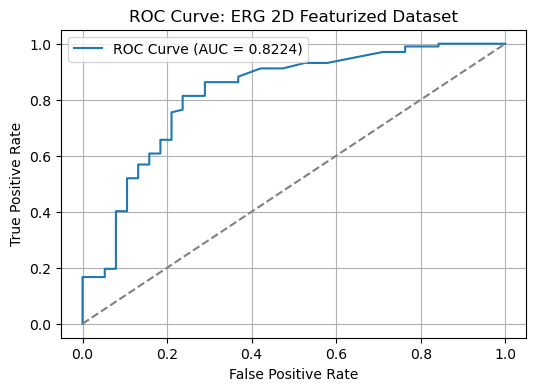

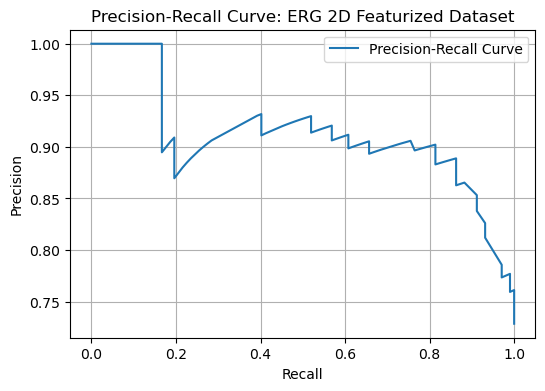

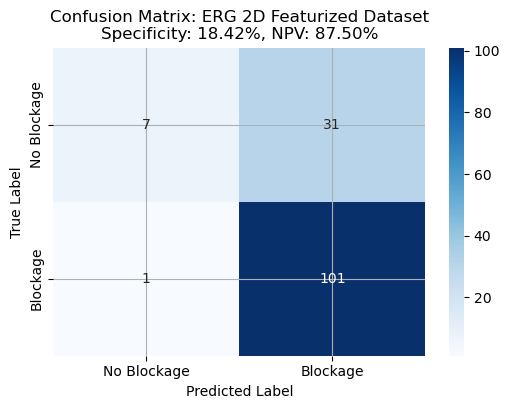

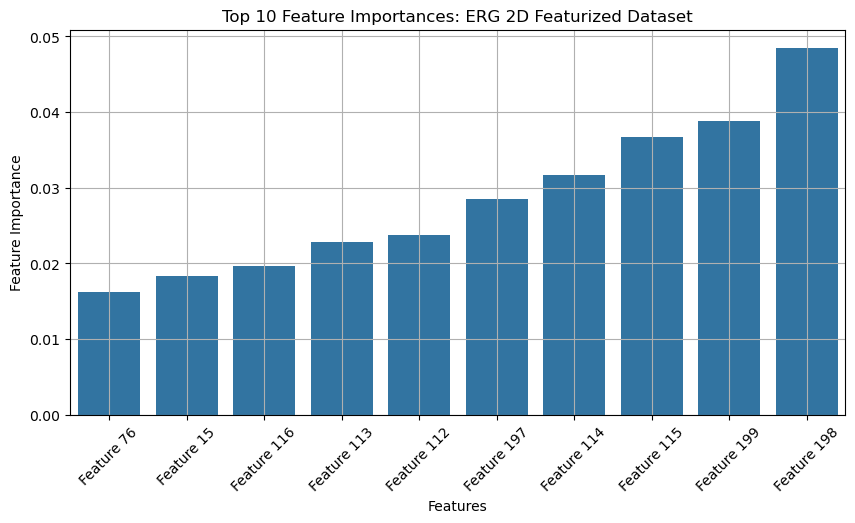

In [31]:
evaluate_model(erg2d_model_results, graph_title = "ERG 2D Featurized Dataset")